# Задание 3.2 - сверточные нейронные сети (CNNs) в PyTorch

Это упражнение мы буде выполнять в Google Colab - https://colab.research.google.com/  
Google Colab позволяет запускать код в notebook в облаке Google, где можно воспользоваться бесплатным GPU!  

Авторы курса благодарят компанию Google и надеятся, что праздник не закончится.

Туториал по настройке Google Colab:  
https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d  
(Keras инсталлировать не нужно, наш notebook сам установит PyTorch)


In [4]:
# Intstall PyTorch and download data
!pip3 install torch torchvision

!wget -c http://ufldl.stanford.edu/housenumbers/train_32x32.mat http://ufldl.stanford.edu/housenumbers/test_32x32.mat

--2021-04-17 15:54:36--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘train_32x32.mat’

train_32x32.mat     100%[===================>] 173.61M  10.7MB/s    in 12s     

2021-04-17 15:54:47 (14.9 MB/s) - ‘train_32x32.mat’ saved [182040794/182040794]

--2021-04-17 15:54:47--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Reusing existing connection to ufldl.stanford.edu:80.
HTTP request sent, awaiting response... 200 OK
Length: 64275384 (61M) [text/plain]
Saving to: ‘test_32x32.mat’

test_32x32.mat      100%[===================>]  61.30M  10.2MB/s    in 4.7s    

2021-04-17 15:54:52 (12.9 MB/s) - ‘test_32x32.mat’ saved [64275384/64275384]

FINISHED --2021-04-17 15:54:52--
Total wall clock time: 17s
Downloaded: 2 files, 235M in

In [5]:
from collections import namedtuple

import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler

from torchvision import transforms

In [6]:
device = torch.device("cuda:0") # Let's make sure GPU is available!

In [ ]:
import platform
platform.machine()

'x86_64'

In [ ]:
platform.version()

'#1 SMP Thu Jul 23 08:00:38 PDT 2020'

In [ ]:
platform.platform()

'Linux-4.19.112+-x86_64-with-Ubuntu-18.04-bionic'

In [ ]:
platform.uname()

uname_result(system='Linux', node='8802b5e59157', release='4.19.112+', version='#1 SMP Thu Jul 23 08:00:38 PDT 2020', machine='x86_64', processor='x86_64')

In [ ]:
platform.processor()

'x86_64'

# Загружаем данные

In [7]:
# First, lets load the dataset
data_train = dset.SVHN('./', 
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('./', split='test', transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

Разделяем данные на training и validation.

На всякий случай для подробностей - https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [8]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

In [9]:
# We'll use a special helper module to shape it into a flat tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

Создадим простейшую сеть с новыми слоями:  
Convolutional - `nn.Conv2d`  
MaxPool - `nn.MaxPool2d`

In [10]:
nn_model = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),    
            Flattener(),
            nn.Linear(64*2*2, 10),
          )

nn_model.type(torch.cuda.FloatTensor)
nn_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-1, weight_decay=1e-4)

Восстановите функцию `compute_accuracy` из прошлого задания.  
Единственное отличие в новом - она должна передать данные на GPU прежде чем прогонять через модель. Сделайте это так же, как это делает функция `train_model`

In [15]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, scheduler = None):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
          
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        if scheduler is not None:
            scheduler.step(ave_loss)
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    correct = 0 
    total = 0 
    with torch.no_grad():
        for i_step, (x, y) in enumerate(loader):
                x = x.to(device)
                y = y.to(device)
                prediction = torch.argmax(model(x) , 1)    
                for i in range(len(prediction)):
                    if prediction[i] == y[i]:
                        correct += 1
                total += len(prediction)
    return float(correct/total)

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 0)

# Аугментация данных (Data augmentation)

В работе с изображениями одним из особенно важных методов является аугментация данных - то есть, генерация дополнительных данных для тренировки на основе изначальных.   
Таким образом, мы получаем возможность "увеличить" набор данных для тренировки, что ведет к лучшей работе сети.
Важно, чтобы аугментированные данные были похожи на те, которые могут встретиться в реальной жизни, иначе польза от аугментаций уменьшается и может ухудшить работу сети.

С PyTorch идут несколько таких алгоритмов, называемых `transforms`. Более подробно про них можно прочитать тут -
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#transforms

Ниже мы используем следующие алгоритмы генерации:
- ColorJitter - случайное изменение цвета
- RandomHorizontalFlip - горизонтальное отражение с вероятностью 50%
- RandomVerticalFlip - вертикальное отражение с вероятностью 50%
- RandomRotation - случайный поворот

In [16]:
tfs = transforms.Compose([
    transforms.ColorJitter(hue=.50, saturation=.50),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(50, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

# Create augmented train dataset
data_aug_train = dset.SVHN('./', 
                       transform=tfs
                      )

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                           sampler=train_sampler)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1201: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"


Визуализируем результаты агментации (вообще, смотреть на сгенерированные данные всегда очень полезно).

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1201: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"


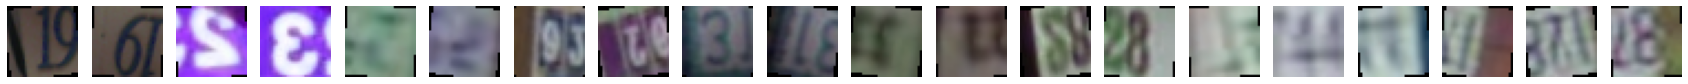

In [17]:
# TODO: Visualize some augmented images!
# hint: you can create new datasets and loaders to accomplish this

# Based on the visualizations, should we keep all the augmentations?

tfs = transforms.Compose([
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
])

data_aug_vis = dset.SVHN('./', 
                       transform=tfs
                      )

plt.figure(figsize=(30, 3))

for i, (x, y) in enumerate(data_aug_vis):
    if i == 20:
        break
    plt.subplot(1, 20, i+1)
    plt.grid(False)
    plt.imshow(x)
    plt.axis('off')

Все ли агментации одинаково полезны на этом наборе данных? Могут ли быть среди них те, которые собьют модель с толку?

Выберите из них только корректные

In [18]:
# TODO: 
tfs = transforms.Compose([
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

# TODO create new instances of loaders with the augmentations you chose
data_aug_train = dset.SVHN('./', 
                       transform=tfs
                      )

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                           sampler=train_sampler)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1201: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"


In [19]:
# Finally, let's train with augmentations!

# Note we shouldn't use augmentations on validation

loss_history, train_history, val_history = train_model(nn_model, train_aug_loader, val_loader, loss, optimizer, 0)

In [20]:
# TODO: 
tfs = transforms.Compose([
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

# TODO create new instances of loaders with the augmentations you chose
data_aug_train = dset.SVHN('./', 
                       transform=tfs
                      )

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                           sampler=train_sampler)


loss_history, train_history, val_history = train_model(nn_model, train_aug_loader, val_loader, loss, optimizer, 0)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1201: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"


In [21]:
# TODO: 
tfs = transforms.Compose([
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

# TODO create new instances of loaders with the augmentations you chose
data_aug_train = dset.SVHN('./', 
                       transform=tfs
                      )

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                           sampler=train_sampler)


loss_history, train_history, val_history = train_model(nn_model, train_aug_loader, val_loader, loss, optimizer, 0)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1201: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"


In [22]:
tfs = transforms.Compose([
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

# TODO create new instances of loaders with the augmentations you chose
data_aug_train = dset.SVHN('./', 
                       transform=tfs
                      )

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                           sampler=train_sampler)


loss_history, train_history, val_history = train_model(nn_model, train_aug_loader, val_loader, loss, optimizer, 0)

In [23]:
# TODO: 
tfs = transforms.Compose([
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

# TODO create new instances of loaders with the augmentations you chose
data_aug_train = dset.SVHN('./', 
                       transform=tfs
                      )

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                           sampler=train_sampler)


loss_history, train_history, val_history = train_model(nn_model, train_aug_loader, val_loader, loss, optimizer, 0)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1201: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"


# LeNet
Попробуем имплементировать классическую архитектуру сверточной нейронной сети, предложенную Яном ЛеКуном в 1998 году. В свое время она достигла впечатляющих результатов на MNIST, посмотрим как она справится с SVHN?
Она описана в статье ["Gradient Based Learning Applied to Document Recognition"](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf), попробуйте прочитать ключевые части и имплементировать предложенную архитетуру на PyTorch.

Реализовывать слои и функцию ошибки LeNet, которых нет в PyTorch, **не нужно** - просто возьмите их размеры и переведите в уже известные нам Convolutional, Pooling и Fully Connected layers.

Если в статье не очень понятно, можно просто погуглить LeNet и разобраться в деталях :)

In [24]:
# TODO: Implement LeNet-like architecture for SVHN task
lenet_model = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, padding=0),
    nn.MaxPool2d(kernel_size=2),
    nn.BatchNorm2d(6),
    nn.ReLU(inplace=True),
    nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, padding=0),
    nn.MaxPool2d(kernel_size=2),
    nn.BatchNorm2d(16),
    nn.ReLU(inplace=True),
    Flattener(),
    nn.Linear(16*5*5, 120),
    nn.BatchNorm1d(120),
    nn.ReLU(inplace=True),
    nn.Linear(120, 84),
    nn.BatchNorm1d(84),
    nn.ReLU(inplace=True),
    nn.Linear(84, 10),
    nn.BatchNorm1d(10))
lenet_model.type(torch.cuda.FloatTensor)
lenet_model.to(device)
loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(lenet_model.parameters(), lr=1e-1, weight_decay=1e-4)

In [25]:
# Let's train it!
loss_history, train_history, val_history = train_model(lenet_model, train_aug_loader, val_loader, loss, optimizer, 0)

# Подбор гиперпараметров

In [28]:
# The key hyperparameters we're going to tune are learning speed, annealing rate and regularization
# We also encourage you to try different optimizers as well

def new_lenet():
    return nn.Sequential( #32x32
nn.Conv2d(3, 64, 3, padding=1), nn.ReLU(inplace=True),
nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(inplace=True),
nn.BatchNorm2d(64),
#---------------------—
nn.MaxPool2d(2), #16x16
#-------------------—
nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(inplace=True),
nn.Conv2d(128, 128, 3, padding=1), nn.ReLU(inplace=True),
nn.BatchNorm2d(128),
#------------------—
nn.MaxPool2d(2), #8x8
#--------------------—
nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(inplace=True),
nn.Conv2d(256, 256, 3, padding=1), nn.ReLU(inplace=True),
nn.Conv2d(256, 256, 3, padding=1), nn.ReLU(inplace=True),
nn.Conv2d(256, 256, 3, padding=1), nn.ReLU(inplace=True),
nn.BatchNorm2d(256),
#------------------—
nn.MaxPool2d(2), #4x4
#--------------------—
nn.Conv2d(256, 512, 3, padding=1), nn.ReLU(inplace=True),
nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(inplace=True),
nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(inplace=True),
nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(inplace=True),
nn.BatchNorm2d(512),
#------------------—
nn.MaxPool2d(2),#2x2
#--------------------—
nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(inplace=True),
nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(inplace=True),
nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(inplace=True),
nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(inplace=True),
nn.BatchNorm2d(512),
#------------------—
nn.MaxPool2d(2), #1x1
#------------------—
Flattener(),
#--------------------—
nn.Linear(512, 1024), nn.ReLU(inplace=True),
nn.BatchNorm1d(1024),
nn.Linear(1024, 10)
)
Hyperparams = namedtuple("Hyperparams", ['learning_rate', 'reg'])
RunResult = namedtuple("RunResult", ['model', 'train_history', 'val_history' ,'final_val_accuracy' ])

learning_rates = [1e-2, 1e-3, 2e-3, 4e-3, 1e-4]
reg = [1e-3, 1e-4, 1e-5, 1e-7]

batch_size = 64
epoch_num = 0

# Record all the runs here
# Key should be Hyperparams and values should be RunResult
run_record = {} 

best_model = None
best_accuracy = 0

for lr in range(0):
  for rg in range(0):
    print("lr: " , lr, " rg: ",rg)
    lenet_model = new_lenet()
    lenet_model.type(torch.cuda.FloatTensor)
    lenet_model.to(device)
    optimizer = optim.Adam(lenet_model.parameters(), lr=lr, weight_decay=rg)
    sheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer , factor = 0.5 , patience= 2 , verbose= False)
    loss_history, train_history, val_history = train_model(lenet_model, train_aug_loader, val_loader, loss, optimizer, epoch_num, sheduler)  
    if val_history[-1] > best_accuracy:
      best_model = lenet_model 
    run_record[Hyperparams(lr, rg)] = RunResult(lenet_model, train_history, val_history , val_history[-1])

In [30]:
best_val_accuracy = None
best_hyperparams = None
best_run = None

for hyperparams, run_result in run_record.items():
    if best_val_accuracy is None or best_val_accuracy < run_result.final_val_accuracy:
        best_val_accuracy = run_result.final_val_accuracy
        best_hyperparams = hyperparams
        best_run = run_result
        
#print("Best validation accuracy: %4.2f, best hyperparams: %s" % (best_val_accuracy, best_hyperparams))
        

# Свободное упражнение - догоним и перегоним LeNet!

Попробуйте найти архитектуру и настройки тренировки, чтобы выступить лучше наших бейзлайнов.

Что можно и нужно попробовать:
- BatchNormalization (для convolution layers он в PyTorch называется [batchnorm2d](https://pytorch.org/docs/stable/nn.html#batchnorm2d))
- Изменить количество слоев и их толщину
- Изменять количество эпох тренировки
- Попробовать и другие агментации

In [31]:
lenet_model = new_lenet()
lenet_model.type(torch.cuda.FloatTensor)
lenet_model.to(device)
optimizer = optim.Adam(lenet_model.parameters(), lr=0.002, weight_decay=1e-05)
sheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer , factor = 0.5 , patience= 2 , verbose= False)
loss_history, train_history, val_history = train_model(lenet_model, train_aug_loader, val_loader, loss, optimizer, 30, sheduler)

Average loss: 2.366947, Train accuracy: 0.151094, Val accuracy: 0.163470
Average loss: 2.316566, Train accuracy: 0.171655, Val accuracy: 0.187223
Average loss: 2.294579, Train accuracy: 0.183121, Val accuracy: 0.180670
Average loss: 2.201486, Train accuracy: 0.205286, Val accuracy: 0.144700
Average loss: 1.351882, Train accuracy: 0.521841, Val accuracy: 0.424271
Average loss: 0.759144, Train accuracy: 0.769000, Val accuracy: 0.837554
Average loss: 0.521396, Train accuracy: 0.849538, Val accuracy: 0.888540
Average loss: 0.383991, Train accuracy: 0.891854, Val accuracy: 0.884240
Average loss: 0.326471, Train accuracy: 0.909719, Val accuracy: 0.907515
Average loss: 0.286382, Train accuracy: 0.922602, Val accuracy: 0.920347
Average loss: 0.268100, Train accuracy: 0.926151, Val accuracy: 0.921917
Average loss: 0.315555, Train accuracy: 0.908985, Val accuracy: 0.926490
Average loss: 0.231138, Train accuracy: 0.937327, Val accuracy: 0.927650
Average loss: 0.216180, Train accuracy: 0.941337, V

# Финальный аккорд - проверим лучшую модель на test set

В качестве разнообразия - напишите код для прогона модели на test set вы.

В результате вы должны натренировать модель, которая покажет более **90%** точности на test set.  
Как водится, лучший результат в группе получит дополнительные баллы!

In [32]:
# TODO Write the code to compute accuracy on test set
final_test_accuracy = compute_accuracy(lenet_model, torch.utils.data.DataLoader(data_test, batch_size=batch_size))
print("Final test accuracy - ", final_test_accuracy)

Final test accuracy -  0.9363475722188076
